## Adding extra levels of potential vorticity and specific humidity to determine their effect

The network is trained using the following python file resnet/whole_mm_indiv_data_adv.py using 5 blocks

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from src.score import *
import re

In [3]:
import pylab as plt

In [5]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])


In [6]:
block_no = 5
var_name = "geo"
unique_list = [500] #100, 250, 300, 400, 500, 600, 700, 850, 925, 1000]

In [7]:
# For the data generator all variables have to be merged into a single dataset.
# For the data generator all variables have to be merged into a single dataset.
if var_name == 'specific_humidity':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'specific_humidity': ('q', unique_list)}
elif var_name == '2m temp':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        '2m_temperature': ('t2m', None)}
elif var_name == 'solar rad':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'toa_incident_solar_radiation': ('tisr', None)}
elif var_name == 'pot_vort':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'potential_vorticity': ('pv', unique_list)}
elif var_name == 'const':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850]),
        'constants': ['lat2d', 'orography', 'lsm']}
elif var_name == 'orig':
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850])} 
elif var_name == 'temp':
    unique_list.append(850)
    unique_list = sorted(list(dict.fromkeys(unique_list)))
    print(unique_list)
    var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', unique_list)}
elif var_name == 'geo':
    unique_list.append(500)
    unique_list = sorted(list(dict.fromkeys(unique_list)))
    var_dict = {
        'geopotential': ('z', unique_list),
        'temperature': ('t', [850])}    

# For the data generator all variables have to be merged into a single dataset.
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]
ds_whole = xr.merge(ds, compat = 'override')

# load all training data
ds_train = ds_whole.sel(time=slice('1979', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)        
            
import re

bs=32
lead_time=72
output_vars = ['z_500', 't_850']

txt = open('dg_train.txt').read()
output = [i.split(': ') for i in txt.split('\n')]

output_mean = [float(output[0][1]), float(output[1][1])]
output_std = [float(output[2][1]), float(output[3][1])]

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=output_mean, std=output_std,
                         shuffle=False, output_vars=output_vars)


Loading data into RAM


## Real data

In [8]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))  

In [9]:
real_unnorm =y1* output_std + output_mean

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

## specific humidity

In [10]:
pred_ensemble_2 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_specific_humidity[150, 200, 250, 300, 500, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_sh_levels = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_2[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_2[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_2 = []

ens_2 = preds_sh_levels.isel(ens = 0).copy()

ens_rmse_list_2.append(compute_weighted_rmse(ens_2, real_ds).compute())

for i in range(1, len(preds_sh_levels.ens)):
    ens_2 += preds_sh_levels.isel(ens = i).copy()
    ens_rmse_list_2.append(compute_weighted_rmse(ens_2/(i+1), real_ds).compute())

In [11]:
ens_rmse_list_2[-1]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.336
    z        float64 452.4

In [11]:
# sh with fewer levels 

pred_ensemble_2a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_specific_humidity[150, 200, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_sh_levelsa = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_2a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_2a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_2a = []

ens_2a = preds_sh_levelsa.isel(ens = 0).copy()

ens_rmse_list_2a.append(compute_weighted_rmse(ens_2a, real_ds).compute())

for i in range(1, len(preds_sh_levelsa.ens)):
    ens_2a += preds_sh_levelsa.isel(ens = i).copy()
    ens_rmse_list_2a.append(compute_weighted_rmse(ens_2a/(i+1), real_ds).compute())

ens_rmse_list_2a[-1:]

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     t        float64 2.365
     z        float64 459.6]

In [12]:
# sh with fewer levels 

pred_ensemble_2b = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_specific_humidity[150, 200, 250, 300, 500, 600, 700, 850].npy')

samples = 20
preds_sh_levelsb = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_2b[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_2b[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_2b = []

ens_2b = preds_sh_levelsb.isel(ens = 0).copy()

ens_rmse_list_2b.append(compute_weighted_rmse(ens_2b, real_ds).compute())

for i in range(1, len(preds_sh_levelsb.ens)):
    ens_2b += preds_sh_levelsb.isel(ens = i).copy()
    ens_rmse_list_2b.append(compute_weighted_rmse(ens_2b/(i+1), real_ds).compute())

ens_rmse_list_2b[-1:]

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 455.8
     t        float64 2.364]

In [13]:
# sh with fewer levels 

pred_ensemble_2c = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_specific_humidity[300, 400, 500, 600, 700, 850].npy')

samples = 20
preds_sh_levelsc = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_2c[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_2c[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_2c = []

ens_2c = preds_sh_levelsc.isel(ens = 0).copy()

ens_rmse_list_2c.append(compute_weighted_rmse(ens_2c, real_ds).compute())

for i in range(1, len(preds_sh_levelsc.ens)):
    ens_2c += preds_sh_levelsc.isel(ens = i).copy()
    ens_rmse_list_2c.append(compute_weighted_rmse(ens_2c/(i+1), real_ds).compute())

ens_rmse_list_2c[-1:]

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 460.4
     t        float64 2.38]

In [14]:
# sh with fewer levels 

pred_ensemble_2d = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_specific_humidity[300, 500, 600, 700, 850, 925, 1000].npy')

samples = 20
preds_sh_levelsd = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_2d[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_2d[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_2d = []

ens_2d = preds_sh_levelsd.isel(ens = 0).copy()

ens_rmse_list_2d.append(compute_weighted_rmse(ens_2d, real_ds).compute())

for i in range(1, len(preds_sh_levelsd.ens)):
    ens_2d += preds_sh_levelsd.isel(ens = i).copy()
    ens_rmse_list_2d.append(compute_weighted_rmse(ens_2d/(i+1), real_ds).compute())

ens_rmse_list_2d[-1:]

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     t        float64 2.363
     z        float64 460.2]

In [18]:
# sh with fewer levels 

pred_ensemble_2e = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_specific_humidity[600, 700, 850, 925, 1000].npy')

samples = 20
preds_sh_levelse = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_2e[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_2e[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_2e = []

ens_2e = preds_sh_levelse.isel(ens = 0).copy()

ens_rmse_list_2e.append(compute_weighted_rmse(ens_2e, real_ds).compute())

for i in range(1, len(preds_sh_levelse.ens)):
    ens_2e += preds_sh_levelse.isel(ens = i).copy()
    ens_rmse_list_2e.append(compute_weighted_rmse(ens_2e/(i+1), real_ds).compute())

ens_rmse_list_2e[-1:]

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 465.5
     t        float64 2.379]

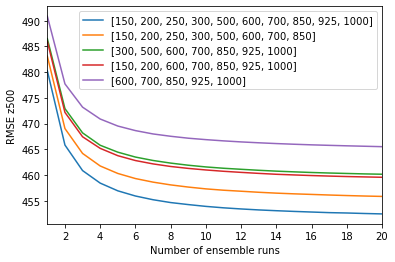

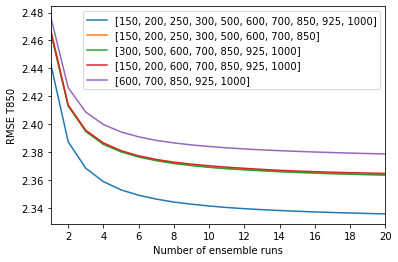

In [24]:
fig, ax = plt.subplots()

from matplotlib.ticker import MaxNLocator

ax.plot([i +1 for i in range(len(ens_rmse_list_2))], [ens_rmse_list_2[i].z for i in range(len(ens_rmse_list_2))], label = '[150, 200, 250, 300, 500, 600, 700, 850, 925, 1000]')    
ax.plot([i +1 for i in range(len(ens_rmse_list_2b))], [ens_rmse_list_2b[i].z for i in range(len(ens_rmse_list_2b))], label = '[150, 200, 250, 300, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_2d))], [ens_rmse_list_2d[i].z for i in range(len(ens_rmse_list_2d))], label = '[300, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_2a))], [ens_rmse_list_2a[i].z for i in range(len(ens_rmse_list_2a))], label = '[150, 200, 600, 700, 850, 925, 1000]')
#plt.plot([i +1 for i in range(len(ens_rmse_list_2c))], [ens_rmse_list_2c[i].z for i in range(len(ens_rmse_list_2c))], label = '[300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_2e))], [ens_rmse_list_2e[i].z for i in range(len(ens_rmse_list_2e))], label = '[600, 700, 850, 925, 1000]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE z500')
ax.set_xlim([1,20])
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot([i +1 for i in range(len(ens_rmse_list_2))], [ens_rmse_list_2[i].t for i in range(len(ens_rmse_list_2))], label = '[150, 200, 250, 300, 500, 600, 700, 850, 925, 1000]')    
ax.plot([i +1 for i in range(len(ens_rmse_list_2b))], [ens_rmse_list_2b[i].t for i in range(len(ens_rmse_list_2b))], label = '[150, 200, 250, 300, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_2d))], [ens_rmse_list_2d[i].t for i in range(len(ens_rmse_list_2d))], label = '[300, 500, 600, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_2a))], [ens_rmse_list_2a[i].t for i in range(len(ens_rmse_list_2a))], label = '[150, 200, 600, 700, 850, 925, 1000]')
#plt.plot([i +1 for i in range(len(ens_rmse_list_2c))], [ens_rmse_list_2c[i].t for i in range(len(ens_rmse_list_2c))], label = '[300, 400, 500, 600, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_2e))], [ens_rmse_list_2e[i].t for i in range(len(ens_rmse_list_2e))], label = '[600, 700, 850, 925, 1000]')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE T850')
ax.set_xlim([1,20])
plt.legend()
plt.show()

## potential vorticity

In [25]:
pred_ensemble_4 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_pot_vort[50, 100, 150, 250, 300, 400, 500, 850, 925].npy')

samples = 20
preds_pv_levels = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_4[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_4[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_4 = []

ens_4 = preds_pv_levels.isel(ens = 0).copy()

ens_rmse_list_4.append(compute_weighted_rmse(ens_4, real_ds).compute())

for i in range(1, len(preds_pv_levels.ens)):
    ens_4 += preds_pv_levels.isel(ens = i).copy()
    ens_rmse_list_4.append(compute_weighted_rmse(ens_4/(i+1), real_ds).compute())
ens_rmse_list_4[-1]    


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 442.5
    t        float64 2.344

In [26]:
pred_ensemble_4a = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_pot_vort[250, 300, 700, 850].npy')

samples = 20
preds_pv_levelsa = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4a[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4a[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_4a = []

ens_4a = preds_pv_levelsa.isel(ens = 0).copy()

ens_rmse_list_4a.append(compute_weighted_rmse(ens_4a, real_ds).compute())

for i in range(1, len(preds_pv_levelsa.ens)):
    ens_4a += preds_pv_levelsa.isel(ens = i).copy()
    ens_rmse_list_4a.append(compute_weighted_rmse(ens_4a/(i+1), real_ds).compute())
ens_rmse_list_4a[-1]    



<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.388
    z        float64 457.5

In [27]:


pred_ensemble_4b = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_pot_vort[250, 300, 400, 500, 700, 850, 925, 1000].npy')

samples = 20
preds_pv_levelsb = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4b[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4b[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_4b = []

ens_4b = preds_pv_levelsb.isel(ens = 0).copy()

ens_rmse_list_4b.append(compute_weighted_rmse(ens_4b, real_ds).compute())

for i in range(1, len(preds_pv_levelsb.ens)):
    ens_4b += preds_pv_levelsb.isel(ens = i).copy()
    ens_rmse_list_4b.append(compute_weighted_rmse(ens_4b/(i+1), real_ds).compute())
ens_rmse_list_4b[-1]    


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.372
    z        float64 453.2

In [28]:

pred_ensemble_4c = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_pot_vort[250, 300, 700, 850, 925, 1000].npy')

samples = 20
preds_pv_levelsc = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4c[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4c[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_4c = []

ens_4c = preds_pv_levelsc.isel(ens = 0).copy()

ens_rmse_list_4c.append(compute_weighted_rmse(ens_4c, real_ds).compute())

for i in range(1, len(preds_pv_levelsc.ens)):
    ens_4c += preds_pv_levelsc.isel(ens = i).copy()
    ens_rmse_list_4c.append(compute_weighted_rmse(ens_4c/(i+1), real_ds).compute())
ens_rmse_list_4c[-1]    


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.385
    z        float64 457.7

In [29]:

pred_ensemble_4d = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_pot_vort[50, 100, 150, 250, 300, 700, 850].npy')

samples = 20
preds_pv_levelsd = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_4d[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    't': xr.DataArray(
        pred_ensemble_4d[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_4d = []

ens_4d = preds_pv_levelsd.isel(ens = 0).copy()

ens_rmse_list_4d.append(compute_weighted_rmse(ens_4d, real_ds).compute())

for i in range(1, len(preds_pv_levelsd.ens)):
    ens_4d += preds_pv_levelsd.isel(ens = i).copy()
    ens_rmse_list_4d.append(compute_weighted_rmse(ens_4d/(i+1), real_ds).compute())
ens_rmse_list_4d[-1]    


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 446.1
    t        float64 2.357

In [30]:

pred_ensemble_4e = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/whole_res_indiv_do_5_pot_vort[150, 250, 300, 700, 850].npy')

samples = 20
preds_pv_levelse = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4e[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4e[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon, 'ens': np.arange(samples), 
                },
    )
})

ens_rmse_list_4e = []

ens_4e = preds_pv_levelse.isel(ens = 0).copy()

ens_rmse_list_4e.append(compute_weighted_rmse(ens_4e, real_ds).compute())

for i in range(1, len(preds_pv_levelse.ens)):
    ens_4e += preds_pv_levelse.isel(ens = i).copy()
    ens_rmse_list_4e.append(compute_weighted_rmse(ens_4e/(i+1), real_ds).compute())
ens_rmse_list_4e[-1]    


<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.35
    z        float64 446.8

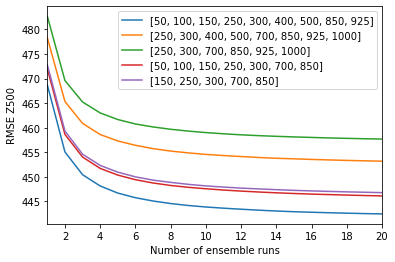

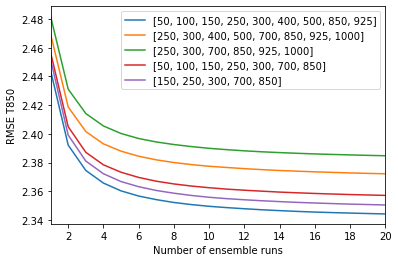

In [34]:
fig, ax = plt.subplots()
ax.plot([i +1 for i in range(len(ens_rmse_list_4))], [ens_rmse_list_4[i].z for i in range(len(ens_rmse_list_4))], label = '[50, 100, 150, 250, 300, 400, 500, 850, 925]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4b))], [ens_rmse_list_4b[i].z for i in range(len(ens_rmse_list_4b))], label = '[250, 300, 400, 500, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4c))], [ens_rmse_list_4c[i].z for i in range(len(ens_rmse_list_4c))], label = '[250, 300, 700, 850, 925, 1000]')
#plt.plot([i +1 for i in range(len(ens_rmse_list_4a))], [ens_rmse_list_4a[i].z for i in range(len(ens_rmse_list_4a))], label = '[250, 300, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4d))], [ens_rmse_list_4d[i].z for i in range(len(ens_rmse_list_4d))], label = '[50, 100, 150, 250, 300, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4e))], [ens_rmse_list_4e[i].z for i in range(len(ens_rmse_list_4e))], label = '[150, 250, 300, 700, 850]')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE Z500')
ax.set_xlim([1,20])
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot([i +1 for i in range(len(ens_rmse_list_4))], [ens_rmse_list_4[i].t for i in range(len(ens_rmse_list_4))], label = '[50, 100, 150, 250, 300, 400, 500, 850, 925]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4b))], [ens_rmse_list_4b[i].t for i in range(len(ens_rmse_list_4b))], label = '[250, 300, 400, 500, 700, 850, 925, 1000]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4c))], [ens_rmse_list_4c[i].t for i in range(len(ens_rmse_list_4c))], label = '[250, 300, 700, 850, 925, 1000]')
#plt.plot([i +1 for i in range(len(ens_rmse_list_4a))], [ens_rmse_list_4a[i].t for i in range(len(ens_rmse_list_4a))], label = '[250, 300, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4d))], [ens_rmse_list_4d[i].t for i in range(len(ens_rmse_list_4d))], label = '[50, 100, 150, 250, 300, 700, 850]')
ax.plot([i +1 for i in range(len(ens_rmse_list_4e))], [ens_rmse_list_4e[i].t for i in range(len(ens_rmse_list_4e))], label = '[150, 250, 300, 700, 850]')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of ensemble runs')
ax.set_ylabel('RMSE T850')
ax.set_xlim([1,20])
plt.legend()
plt.show()


In [ ]:
# pv [150, 250, 300, 700, 850]
# sh [300, 500, 600, 700, 850, 925, 1000]

In [36]:
ens_1_avg = ens_4e/20
ens_1_avg.to_netcdf('/rds/general/user/mc4117/ephemeral/saved_pred/pv_5_levels_preds.nc')

ens_1_avg = ens_2d/20
ens_1_avg.to_netcdf('/rds/general/user/mc4117/ephemeral/saved_pred/sh_5_levels_preds.nc')